# Joint GRAPPA reconstruction demo 
###### Author: Zimu Huo
###### Date: 07.2022

I will skip the details of GRAPPA. 

bSSFP suffers from unique banding artifacts, which are commonly corrected by using multiple phase cycles. These banding artifacts are a form of spatial modulation. While it is tricky to exploit this with SENSE (you will need coil maps and bssfp profile maps), this additional redundancy can be easily utilized by GRAPPA. To achieve this, we simply extend the GRAPPA kernel to include the phase cycle dimensions.

-------------------------------------------------------------------------
References
    
    [1] 
    Author: Berkin Bilgic et al. 
    Title: Joint Reconstruction for Phase-Cycled Balanced SSFP
    Link: https://martinos.org/~berkin/2016_08_06_bssfp_abstract.pdf
    

In [2]:
import sys
sys.path.insert(1, '../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
import util.mask as undersample
from util.fft import *
import util.simulator as simulate
from util.jg import *

In [3]:
from math import log10, sqrt
import cv2
import numpy as np
  
def PSNR(original, compressed):
    original = abs(original)
    compressed = abs(compressed)
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
    
def plot_singular_values(matrix):
    # Compute the singular values
    singular_values = np.linalg.svd(matrix, compute_uv=False)
    # print(singular_values[1]/singular_values[-1])
    
    # Plotting the singular values
    plt.figure(figsize=(8, 4))
    plt.plot(singular_values, 'o-')
    plt.title('Singular Values')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.grid(True)
    plt.show()
    
def joint_grappa_weights(calib, R, kh = 4, kw = 5, lamda = 3e-3):
    #train kernel 
    [ncy, ncx, pc, nc] = calib.shape
    ks = pc*nc*kh*kw
    nt = (ncy-(kh-1)*R)*(ncx-(kw-1))
    inMat=np.zeros([nt, ks], dtype = complex)
    outMat=np.zeros([nt,(R-1),pc, nc], dtype = complex)
    n = 0
    for x in ((np.arange(np.floor(kw/2),ncx-np.floor(kw/2), dtype=int))):
        for y in (np.arange(ncy-(kh-1)*R)):
            inMat[n,...] = calib[y:y+kh*R:R, int(x-np.floor(kw/2)):int(x+np.floor(kw/2))+1,:,:].reshape(1,-1)
            outMat[n,...] = calib[int(y+np.floor((R*(kh-1)+1)/2) - np.floor(R/2))+1:int(y+np.floor((R*(kh-1)+1)/2)-np.floor(R/2)+R),x,:,:]
            n = n + 1  
    weight = np.zeros([(R-1), ks, pc, nc], dtype = complex)
    # plot_singular_values(inMat)
    # Solve on a per-coil, per-phase cycle basis. You can also flatten these dimensions to jointly solve across coils and phase cycles.
    if lamda: 
        [u,s,vh] = np.linalg.svd(inMat,full_matrices=False)
        s_inv = np.conj(s) / (np.abs(s)**2 + lamda);
        inMat_inv = vh.conj().T @ np.diag(s_inv) @ u.conj().T;
        for c in range(nc):
            for p in range(pc):
                weight[:,:,p,c] = (inMat_inv @ outMat[:,:,p,c]).T;
    else:
        for c in range(nc): 
            for p in range(pc):
                weight[:,:,p,c] = (np.linalg.pinv(inMat) @ outMat[:,:,p,c]).T;
    return weight

def joint_grappa(dataR, calib, kh = 4, kw = 5, lamda = 0,combine =True, w= None, R = None):
    if R is None:
        mask = np.where(dataR[:,0,0] == 0, 0, 1).flatten()
        R = int(np.ceil(mask.shape[0]/np.sum(mask)))

    acs = calib
    [ny, nx, pc, nc] = dataR.shape
    if w is None: 
        w = joint_grappa_weights(acs, R, kh, kw, lamda)

    data = np.zeros([ny, nx, pc, nc], dtype = complex)
    for x in (range(nx)):
        xs = get_circ_xidx(x, kw, nx)
        for y in range (0,ny,R):
            ys = np.mod(np.arange(y, y+(kh)*R, R), ny)
            yf = get_circ_yidx(ys, R, kh, ny)
            kernel = dataR[ys, :, :,:][:, xs,:,:].reshape(-1,1)
            for c in range(nc):
                for p in range(pc):
                    data[yf, x, p,c] = np.matmul(w[:,:,p,c], kernel).flatten()
    data += dataR
    
    images = ifft2c(data) 
    if combine:
        return rsos(rsos(images,-1),-1)
    else: 
        return images

def get_circ_xidx(x, kw, nx):
    return np.mod(np.linspace(x-np.floor(kw/2), x+np.floor(kw/2), kw,dtype = int),nx)
def get_circ_yidx(ys, R, kh, ny):
    return np.mod(np.linspace(ys[kh//2-1]+1, np.mod(ys[kh//2]-1,ny), R-1, dtype = int), ny) 

In [4]:
data = np.load("../lib/ssfp_pc8.npy")
rawImage = ifft2c(data)
truth = rsos(rsos(rawImage,-1),-1)
[ny, nx, pc, nc] = data.shape
acs = simulate.acs(data, (32, 32))
dataR = np.zeros(data.shape, dtype = complex)
R = 4
dataR[::R] = data[::R]

In [5]:
standard_recon = np.zeros([ny, nx, pc], dtype = complex)
for p in range(pc):
    standard_recon[:,:,p] = grappa(dataR[:,:,p,:], acs[:,:,p,:], 2, 7)
standard_recon = rsos(standard_recon)

In [6]:
joint_recon = joint_grappa(dataR, acs, 2, 7, lamda = 6e-3)

In [7]:
print(PSNR(truth,standard_recon))
print(PSNR(truth,joint_recon)) # better results with joint recon

27.094985460267612
29.09919849032342


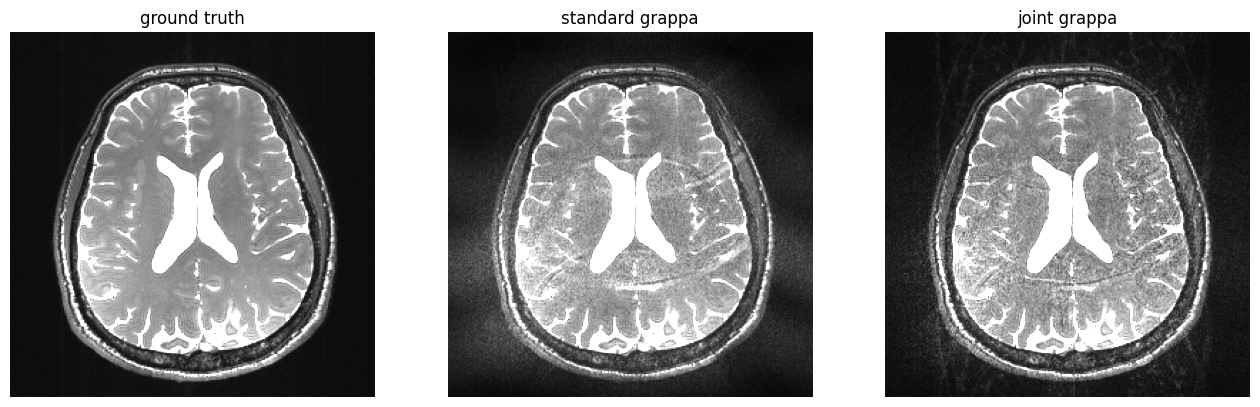

In [8]:
plt.figure(figsize=(16,12))
plt.subplot(131)
plt.imshow(np.abs(truth),cmap='gray', vmin = 0,  vmax = 120)
plt.title("ground truth")
plt.axis('off')
plt.subplot(132)
plt.imshow(np.abs(standard_recon),cmap='gray', vmin = 0,  vmax = 120)
plt.title("standard grappa")
plt.axis('off')
plt.subplot(133)
plt.imshow(np.abs(joint_recon),cmap='gray', vmin = 0,  vmax = 120)
plt.title("joint grappa")
plt.axis('off')
plt.show()